In [1]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import torchio as tio
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

from segmenter import Segmenter

In [3]:
checkpoint = "C:/Users/denni/Documents/fallstudie-ss2024/logs/lightning_logs/version_12/checkpoints/epoch=44-step=23130.ckpt"
model = Segmenter.load_from_checkpoint(checkpoint, activation_fn=torch.nn.ReLU())

In [4]:
device = "cuda:0"
model.eval()
model.to(device)

Segmenter(
  (model): UNet(
    (layer1): DoubleConv(
      (step): Sequential(
        (0): Conv3d(4, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): ReLU()
        (2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (3): ReLU()
      )
    )
    (layer2): DoubleConv(
      (step): Sequential(
        (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): ReLU()
        (2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (3): ReLU()
      )
    )
    (layer3): DoubleConv(
      (step): Sequential(
        (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): ReLU()
        (2): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (3): ReLU()
      )
    )
    (layer4): DoubleConv(
      (step): Sequential(
        (0): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), p

In [5]:
def change_img_to_label_path(path):
    """ Returns all directories in a path. """
    parts = list(path.parts)
    # Replace path
    parts[parts.index("imagesTr")] = "labelsTr"
    return Path(*parts)

In [6]:
path = Path("D:/Deep Learning/Task01_BrainTumour/imagesTr")
subject_paths = list(path.glob("BRATS_*"))
subjects = []

for subject_path in subject_paths:
    label_path = change_img_to_label_path(subject_path)
    subject = tio.Subject({"MRI": tio.ScalarImage(subject_path), 
                        "Label": tio.LabelMap(label_path)})
    subjects.append(subject)

In [8]:
process = tio.Compose([
    tio.CropOrPad((240, 240, 155)),
    tio.RescaleIntensity((-1, 1))
])

# The augmentation creates new imaages with scales between 0.9 and 1.1 as well as rotating by between -10 degrees and 10
# degrees.
augmentation = tio.RandomAffine(scales=(0.9, 1.1), degrees=(-25, 25))

# The validatoin only gets the preprocessed data, whereas we create new images for the test data in the form of
# augmented data with the above transformations.
val_transform = process
train_transform = tio.Compose([process, augmentation])

In [9]:
num_train_elements = 411

In [11]:
train_dataset = tio.SubjectsDataset(subjects[:num_train_elements], transform=train_transform)
val_dataset = tio.SubjectsDataset(subjects[num_train_elements:], transform=val_transform)

# The sampler decides with what probability each label should occur in the training. This allows us to oversample
# the tumors by assigning the tumor label a higher probability. Specifically, background (label 0) has probability
# 0.2, liver (label 1) has probability 0.3, and tumor (label 2) has probability 0.5.
sampler = tio.data.LabelSampler(patch_size=96, label_name="Label", 
                                label_probabilities={0: 0.4, 1: 0.3, 2: 0.15, 3: 0.15})

In [12]:
train_patches_queue = tio.Queue(
    train_dataset,
    max_length=40,
    samples_per_volume=5,
    sampler=sampler,
    num_workers=4
)

val_patches_queue = tio.Queue(
    val_dataset,
    max_length=40,
    samples_per_volume=5,
    sampler=sampler,
    num_workers=4
)

In [13]:
train_loader = torch.utils.data.DataLoader(train_patches_queue, batch_size=2, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_patches_queue, batch_size=2, num_workers=0)

In [94]:
def show_mri_and_label(subject_num, slice_num, show_label=True, train=False):
    plt.figure()
    ground_truth = val_dataset if not train else train_dataset
    plt.imshow(ground_truth[subject_num]["MRI"].data[0,:,:,slice_num], cmap="bone")
    if show_label:
        plt.imshow(masked(ground_truth[subject_num]["Label"].data[0,:,:,slice_num]), alpha=0.5,
                                  cmap="autumn")
    title_start = "Training" if train else "Eval"
    plt.title(f"{title_start} subject {subject_num}, slice {slice_num}")
    plt.suptitle("Ground truth", y=0.05, fontsize=10)

In [95]:
IDX = 8

In [96]:
grid_sampler = tio.inference.GridSampler(val_dataset[IDX], 96, (8, 8, 8))
aggregator = tio.inference.GridAggregator(grid_sampler)
patch_loader = torch.utils.data.DataLoader(grid_sampler, batch_size=4)

In [97]:
with torch.no_grad():
    for patches_batch in patch_loader:
        input_tensor = patches_batch["MRI"]["data"].to(device)
        locations = patches_batch[tio.LOCATION]
        pred = model(input_tensor)
        # We keep adding batches to the aggregator to later collect all the data.
        aggregator.add_batch(pred, locations)

In [98]:
pred = aggregator.get_output_tensor()

In [99]:
pred.shape

torch.Size([4, 240, 240, 155])

In [100]:
pred.argmax(0).shape

torch.Size([240, 240, 155])

In [101]:
def masked(a):
    return np.ma.masked_where(a == 0, a)

In [102]:
def show_mri_and_pred(subject_num, slice_num, pred, train=False):
    plt.figure()
    ground_truth = val_dataset if not train else train_dataset
    plt.imshow(ground_truth[subject_num]["MRI"].data[0,:,:,slice_num], cmap="bone")
    max_likelihood_pred = pred.argmax(0)
    plt.imshow(masked(max_likelihood_pred[:, :, slice_num]), alpha=0.5,
                                  cmap="autumn")
    title_start = "Training" if train else "Eval"
    plt.title(f"{title_start} subject {subject_num}, slice {slice_num}")
    plt.suptitle("Prediction", y=0.05, fontsize=10)

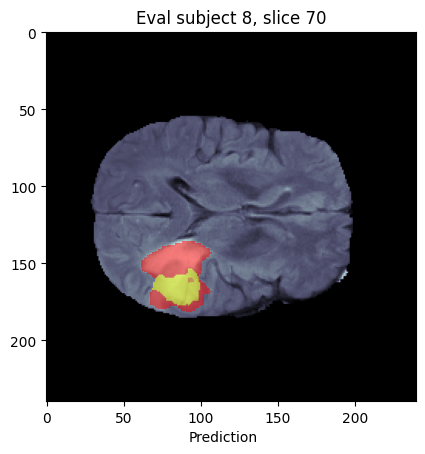

In [103]:
show_mri_and_pred(IDX, 70, pred)

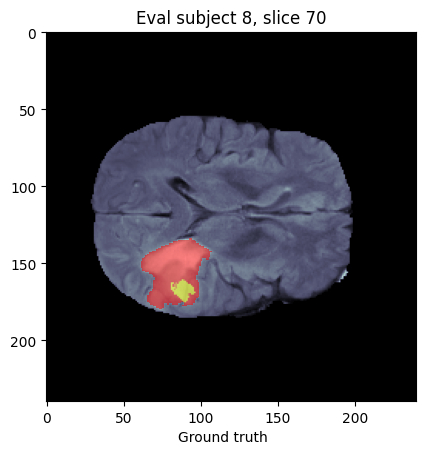

In [104]:
show_mri_and_label(IDX, 70, True)

In [136]:
def show_all(subject_num, slice_num, pred, train=False):
    plt.figure(figsize=(20, 20))
    f, ax = plt.subplots(2)
    # Show ground truth image
    ground_truth = val_dataset if not train else train_dataset
    ax[0].set_position([0, 0, 0.8, 0.8])
    ax[0].imshow(ground_truth[subject_num]["MRI"].data[0,:,:,slice_num], cmap="bone")
    ax[0].imshow(masked(ground_truth[subject_num]["Label"].data[0,:,:,slice_num]), alpha=0.5,
                                  cmap="autumn")
    title_start = "Training" if train else "Eval"
    ax[0].set_title(f"{title_start} subject {subject_num}, slice {slice_num} \n(ground truth)")
    # ax[0].legend("Ground truth", y=0.05, fontsize=10)
    
    # Show prediction image
    ground_truth = val_dataset if not train else train_dataset
    ax[1].set_position([0.75, 0, 0.8, 0.8])
    ax[1].imshow(ground_truth[subject_num]["MRI"].data[0,:,:,slice_num], cmap="bone")
    max_likelihood_pred = pred.argmax(0)
    ax[1].imshow(masked(max_likelihood_pred[:, :, slice_num]), alpha=0.5,
                                  cmap="autumn")
    title_start = "Training" if train else "Eval"
    ax[1].set_title(f"{title_start} subject {subject_num}, slice {slice_num} \n(pred)")
    # ax[0].legend("Prediction", y=0.05, fontsize=10)

<Figure size 2000x2000 with 0 Axes>

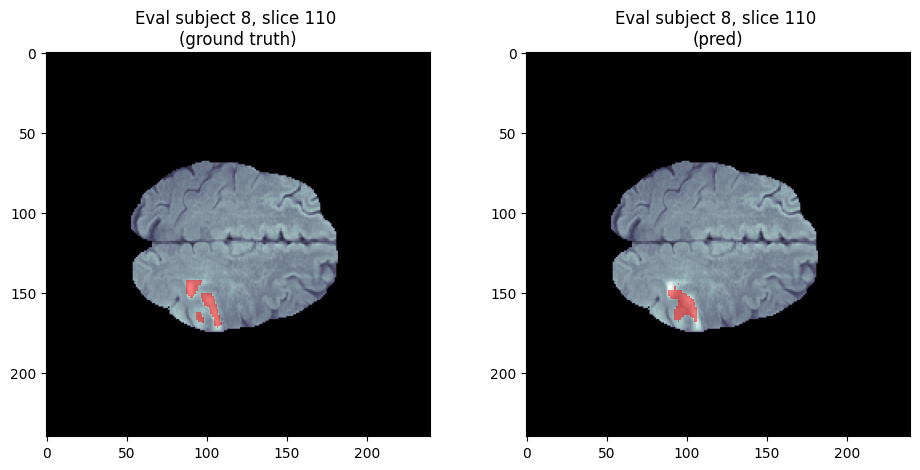

In [150]:
show_all(IDX, 110, pred)

In [26]:
subjects[12]["MRI"].data.unsqueeze(0).shape

torch.Size([1, 4, 240, 240, 155])

In [27]:
model(subjects[12]["MRI"].data.unsqueeze(0).cuda())

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 76 but got size 77 for tensor number 1 in the list.

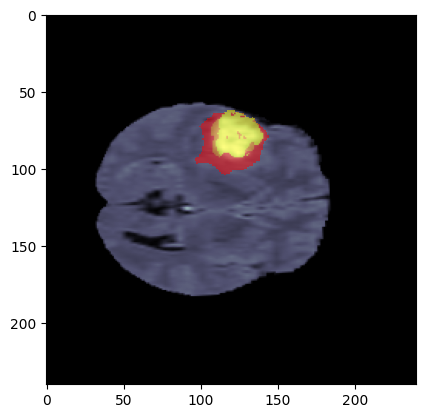

In [12]:
show_mri_and_label(3, 70, True)

In [ ]:
def show_mri_and_pred(subject_num, slice_num, model):
    plt.figure()
    plt.imshow(subjects[subject_num]["MRI"].data[0,:,:,slice_num], cmap="bone")
    if show_label:
        plt.imshow(masked(subjects[subject_num]["Label"].data[0,:,:,slice_num]), alpha=0.5,
                                  cmap="autumn")